File for all CV Methods combined so that it runs in a single pipeline

1) To install all required packages for this pipeline, use the `installPackages.sh` script.

In [5]:
!python -m pip install -r requirements.txt
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' #needs to be installed manually if needed; remove ObjectDetection class if not needed

INFO: pip is looking at multiple versions of tabulate to determine which version is compatible with other requirements. This could take a while.
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
INFO: pip is looking at multiple versions of stack-data to determine which version is compatible with other requirements. This could take a while.
  Using cached stack_data-0.6.2-py3-none-any.whl (24 kB)
INFO: pip is looking at multiple versions of soupsieve to determine which version is compatible with other requirements. This could take a while.
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
INFO: pip is looking at multiple versions of sniffio to determine which version is compatible with other requirements. This could take a while.
  Using cached sniffio-1.3.0-py3-none-any.whl (10 kB)
INFO: pip is looking at multiple versions of six to determine which version is compatible with other requirements. This could take a while.
  Using cached six-1.12.0-py2.py3-none-any.whl (10

ERROR: Cannot install -r requirements.txt (line 40), google-auth==1.4.2 and tensorboard==2.11.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


2) Imports

In [36]:
import csv, json, os, math, pathlib, random, re, sys, statistics, time
import numpy as np
import pandas as pd
import cv2
import torch, torchvision
import pylab
#import detectron2

from natsort import natsorted, ns
from colorthief import ColorThief
from fer import FER
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io as io #scikit-image

from torch.autograd import Variable as V
from torchvision import transforms as trn
from torch.nn import functional as F
import torchvision.models as models

#from detectron2.utils.logger import setup_logger
#from detectron2 import model_zoo
#from detectron2.engine import DefaultPredictor
#from detectron2.config import get_cfg
#from detectron2.utils.visualizer import Visualizer, ColorMode
#from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
#setup logger for detectron2
#setup_logger()

In [52]:
class Configuration:

  def __init__(self):
    with open("./config.json", "rb") as file:
      self.config = json.load(file)
    
    self.inputRoot = pathlib.Path(self.config["inputRoot"])
    self.outputRoot = pathlib.Path(self.config["outputRoot"])

  def getInputRoot(self):
    return self.config["inputRoot"] + "\\"

  def getOutputRoot(self):
    return self.config["outputRoot"] + "\\"

  def getGameNames(self):
    return [gameName for gameName in self.config["games"]]

  def getMethodNames(self):
    return self.config["methods"]

  def checkInputFolder(self):
    """
      Checks if the base input path has directories for each game. Also checks if each directory has game images, otherwise prints warnings.
      Not checking might result in an error because there is no folder to write to. This methods raises expections if folders are missing
      and warns if there are folders or files that are not defined in config.json.
    """
    gameNames = self.getGameNames()
    
    for gameFolder in self.inputRoot.iterdir():
      if gameFolder.is_dir() and gameFolder.name in gameNames:
        gameNames.remove(gameFolder.name)

        if not any(gameFolder.iterdir()):
          print(f"WARNING: {gameFolder} contains no game images")
      else:
        print(f"WARNING: {gameFolder} not in games or not a directory")

    if len(gameNames) != 0:
      raise Exception(f"there are the following missing folders: {', '.join(gameNames)}")

    print("Input folder is ok.")
  
  def checkOutputFolder(self):
    """
      Checks if the base output path has directories for each CV method. Also checks if each directory has subfolders for each game.
      Not checking might result in an error because there is no folder to write to. This methods raises expections if folders are missing
      and warns if there are folders or files that are not defined in config.json. Prints warning if folders contain files that might
      be overwritten.
    """
    methodNames = self.getMethodNames()
    
    for methodFolder in self.outputRoot.iterdir():
      if methodFolder.is_dir() and methodFolder.name in methodNames:
        methodNames.remove(methodFolder.name)

        games = pathlib.Path(methodFolder)
        gameNames = self.getGameNames()

        for gameFolder in games.iterdir():
          if gameFolder.is_dir() and gameFolder.name in gameNames:
            gameNames.remove(gameFolder.name)

            if any(gameFolder.iterdir()):
              print(f"WARNING: {gameFolder} contains files")  
          else:
            print(f"WARNING: {gameFolder} not in games or not a directory")
          pass

        if len(gameNames) != 0:
          raise Exception(f"there are the following missing folders in {methodFolder}: {', '.join(gameNames)}")

      else:
        print(f"WARNING: {methodFolder} not in methods or not a directory")

    if len(methodNames) != 0:
      raise Exception(f"there are the following missing folders: {', '.join(methodNames)}")

    print("Output folder is ok.")

  def getFileLength(self):
    numGames = 0
    gameNames = self.getGameNames()
    
    for gameFolder in self.inputRoot.iterdir():
      if gameFolder.is_dir() and gameFolder.name in gameNames:
        numGames += len(list(gameFolder.iterdir()))
    
    return numGames

In [38]:
class AgeGender:

  def __init__(self, gameName, outputPath):
    self.method = "AgeGender"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"
    self.outputPathImages = f"{self.outputPathCSV}\\{self.gameName}\\"
  
    # Defined the model files
    self.FACE_PROTO = "./models/opencv_face_detector.pbtxt"
    self.FACE_MODEL = "./models/opencv_face_detector_uint8.pb"
    self.AGE_PROTO = "./models/age_deploy.prototxt"
    self.AGE_MODEL = "./models/age_net.caffemodel"
    self.GENDER_PROTO = "./models/gender_deploy.prototxt"
    self.GENDER_MODEL = "./models/gender_net.caffemodel"

    # Load network
    self.FACE_NET = cv2.dnn.readNet(self.FACE_MODEL, self.FACE_PROTO)
    self.AGE_NET = cv2.dnn.readNet(self.AGE_MODEL, self.AGE_PROTO)
    self.GENDER_NET = cv2.dnn.readNet(self.GENDER_MODEL, self.GENDER_PROTO)

    self.MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    self.AGE_LIST = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]
    self.GENDER_LIST = ["Male", "Female"]

    self.box_padding = 20

    self.frameName = []
    self.person = []
    self.boxFace = []
    self.gen = []
    self.gender_conf = []
    self.ages = []
    self.age_conf = []

  def get_face_box (self, net, frame, conf_threshold = 0.5):
    frame_copy = frame.copy()
    frame_height = frame_copy.shape[0]
    frame_width = frame_copy.shape[1]
    blob = cv2.dnn.blobFromImage(frame_copy, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    boxes = []

    for i in range(detections.shape[2]):
      confidence = detections[0, 0, i, 2]

      if confidence > conf_threshold:
        x1 = int(detections[0, 0, i, 3] * frame_width)
        y1 = int(detections[0, 0, i, 4] * frame_height)
        x2 = int(detections[0, 0, i, 5] * frame_width)
        y2 = int(detections[0, 0, i, 6] * frame_height)
        boxes.append([x1, y1, x2, y2])
        cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height / 150)), 8)

    return frame_copy, boxes

  def handleNextImage(self, fileName, image):
    resized_image = cv2.resize(image, (640, 480))

    frame = resized_image.copy()
    frame_face, boxes = self.get_face_box(self.FACE_NET, frame)

    count = 0
    for box in boxes:
      self.frameName.append(fileName)
      self.person.append(count)
      self.boxFace.append(box)
      face = frame[max(0, box[1] - self.box_padding):min(box[3] + self.box_padding, frame.shape[0] - 1), \
        max(0, box[0] - self.box_padding):min(box[2] + self.box_padding, frame.shape[1] - 1)]

      blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), self.MODEL_MEAN_VALUES, swapRB = False)
      self.GENDER_NET.setInput(blob)
      gender_predictions = self.GENDER_NET.forward()
      gender = self.GENDER_LIST[gender_predictions[0].argmax()]
      self.gen.append(gender)
      self.gender_conf.append(gender_predictions[0].max())

      self.AGE_NET.setInput(blob)
      age_predictions = self.AGE_NET.forward()
      age = self.AGE_LIST[age_predictions[0].argmax()]
      self.ages.append(age)
      self.age_conf.append(age_predictions[0].max())

      label = "{},{}".format(gender, age)
      cv2.putText(frame_face, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
      cv2.putText(frame_face, str(count), (box[0] + 2, box[1] + 15), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1,cv2.LINE_AA, )

      count += 1

    #only saves an image if age/gender was found
    if len(boxes) > 0:
      cv2.resize(frame_face, (640, 480))
      cv2.imwrite(f"{self.outputPathImages}{fileName}", frame_face)

  def dataToCSV(self):
    if len(self.frameName) > 0:
      df = pd.DataFrame(list(zip(self.frameName, self.person, self.boxFace, self.gen, self.gender_conf, self.ages, self.age_conf)))
      df.columns = ['Name', 'person', 'box', 'gender', 'gender_conf', 'age', 'age_conf']
      df.to_csv(f"{self.outputPathCSV}{self.gameName}.csv")

In [39]:
class BrightnessAnalyzer:

  def __init__(self, gameName, outputPath):
    self.method = "Brightness"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"
    
    self.brightness_dict = {}
    self.brightness_values_dict = {}
    self.statistic_result_dict = {}

  def handleNextImage(self, fileName, image):
    greyscale_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_brightness = greyscale_img.mean()/255

    self.brightness_values_dict[fileName] = img_brightness

    self.brightness_dict[fileName] = []
    self.brightness_dict[fileName].append(round(img_brightness, 2))
    self.brightness_dict[fileName].append(fileName)

  def dataToCSV(self):
    mean_brightness = sum(self.brightness_values_dict.values()) / len(self.brightness_dict)
    sd_brightness = statistics.stdev(self.brightness_values_dict.values())
    median_brightness = statistics.stdev(self.brightness_values_dict.values())
    min_brightness = min(self.brightness_values_dict.values())
    max_brightness = max(self.brightness_values_dict.values())

    statistic_result_dict = {}
    statistic_result_dict["min"] = []
    statistic_result_dict["min"].append(round(min_brightness, 2))
    statistic_result_dict["median"] = []
    statistic_result_dict["median"].append(round(median_brightness, 2))
    statistic_result_dict["mean"] = []
    statistic_result_dict["mean"].append(round(mean_brightness, 2))
    statistic_result_dict["sd"] = []
    statistic_result_dict["sd"].append(round(sd_brightness, 2))
    statistic_result_dict["max"] = []
    statistic_result_dict["max"].append(round(max_brightness, 2))

    dataBrightness = pd.DataFrame.from_dict(self.brightness_dict, orient='index', columns=["brightness_value", "frame"])
    dataResults = pd.DataFrame.from_dict(statistic_result_dict)

    cols = dataBrightness.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataBrightness = dataBrightness[cols]

    dataBrightness.to_csv(f"{self.outputPathCSV}{self.gameName}_Brightness.csv", encoding="utf-8", index=False)

    cols = dataResults.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataResults = dataResults[cols]
    
    dataResults.to_csv(f"{self.outputPathCSV}{self.gameName}_Statistics.csv", encoding="utf-8", index=False)

  def generateGreyScaleGraph(self):
    brightness_values_list = self.brightness_values_dict.items()

    x, y = zip(*brightness_values_list)

    plt.plot(y, color="navy")
    plt.xlabel("frame")
    plt.ylabel("greyscale value")

    #plt.title("Grayscale values ​​for " + self.gameName , fontsize= 15, pad=20)
    #plt.legend(["greyscale value 0 = complete black image\ngreyscale value 1 = complete white image"])

    plt.savefig(f"{self.outputPathCSV}{self.gameName}_Graph.eps", format='eps')


In [88]:
class CustomColorThief(ColorThief):
  def __init__(self, image):
    self.image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

class DominantColor:
  def __init__(self, gameName, outputPath):
    self.method = "DominantColor"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"

    self.dominant_color_arr = []
    self.frameNames = []

  def handleNextImage(self, frameName, image):
    ct_frame = CustomColorThief(image)
    # change quality to "2" to get the second most dominat color
    dominant_color_of_ct_frame = ct_frame.get_color(quality=1)
    self.dominant_color_arr.append(dominant_color_of_ct_frame)
    self.frameNames.append(frameName)

  def generateColorBars(self):
    plt.ioff()
    plt.imshow([[self.dominant_color_arr[i] for i in range(len(self.dominant_color_arr))]], extent=[0,len(self.dominant_color_arr),0,1], aspect='auto')
    plt.ion()

    # axis adjustments
    plt.xlabel("frame")
    plt.ylabel("dominant color")
    plt.yticks([])

    # enable the line if you want your plot to have a title
    #plt.title("DominantColorBarcode for " + self.gameName, fontsize= 15, pad=20)

    plt.savefig(f"{self.outputPathCSV}{self.gameName}_dominant_color_for_each_frame.eps", format='eps')
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_dominant_color_for_each_frame.svg", format='svg')
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_dominant_color_for_each_frame.png")
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_dominant_color_for_each_frame.jpg")

    plt.close()
  
  def dataToCSV(self):
    dominant_color_dict = {}

    for idx, frame_name in enumerate(self.dominant_color_arr):
      dominant_color_dict[frame_name] = []
      dominant_color_dict[frame_name].append(self.dominant_color_arr[idx])
      dominant_color_dict[frame_name].append(self.frameNames[idx])

    dominant_color_row_data = pd.DataFrame.from_dict(dominant_color_dict, orient='index', columns=["RGB", "frame"])
    
    cols_row_data = dominant_color_row_data.columns.tolist()
    cols_row_data = cols_row_data[-1:] + cols_row_data[:-1]
    dominant_color_row_data = dominant_color_row_data[cols_row_data]
    
    dominant_color_row_data.to_csv(f"{self.outputPathCSV}{self.gameName}_dominant_color_row_data.csv", encoding="utf-8", index=False)

In [68]:
class AverageColor:

  def __init__(self, gameName, outputPath):
    self.method = "AverageColor"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"

    self.averageColorArr = []
    self.frameNames = []

  def handleNextImage(self, frameName, image):
    average_color_row = np.average(image, axis=0)
    average_color = np.average(average_color_row, axis=0)

    average_color_tuple = tuple(average_color)

    self.averageColorArr.append(average_color_tuple)
    self.frameNames.append(frameName)

  def generateColorBars(self):
    self.averageColorArr = tuple(tuple(map(int, tup)) for tup in self.averageColorArr)
    
    plt.ioff()
    plt.imshow([[self.averageColorArr[i] for i in range(len(self.averageColorArr))]], extent=[0,len(self.averageColorArr),0,1], aspect='auto')
    plt.ioff()

    # axis adjustments
    plt.xlabel("frame")
    plt.ylabel("average color")
    plt.yticks([])

    # enable the line if you want your plot to have a title
    #plt.title("AverageColorBarcode for " + self.gameName, fontsize= 15, pad=20)

    plt.savefig(f"{self.outputPathCSV}{self.gameName}_average_color_for_each_frame.eps", format='eps')
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_average_color_for_each_frame.svg", format='svg')
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_average_color_for_each_frame.png")
    #plt.savefig(f"{self.outputPathCSV}{self.gameName}_average_color_for_each_frame.jpg")

    plt.close()

  def dataToCSV(self):
    average_color_dict = {}

    for idx, frame_name in enumerate(self.averageColorArr):
      average_color_dict[frame_name] = []
      average_color_dict[frame_name].append(self.averageColorArr[idx])
      average_color_dict[frame_name].append(self.frameNames[idx])

    average_color_row_data = pd.DataFrame.from_dict(average_color_dict, orient='index', columns=["RGB", "frame"])
    
    cols_row_data = average_color_row_data.columns.tolist()
    cols_row_data = cols_row_data[-1:] + cols_row_data[:-1]
    average_color_row_data = average_color_row_data[cols_row_data]
    
    average_color_row_data.to_csv(f"{self.outputPathCSV}{self.gameName}_average_color_row_data.csv", encoding="utf-8", index=False)

In [70]:
class EmotionDetection:

  def __init__(self, gameName, outputPath):
    self.method = "Emotion"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"
    self.outputPathImages = f"{self.outputPathCSV}\\{self.gameName}\\"

    self.detectorMT = FER(mtcnn=True)

    self.emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    self.categories = ['box', 'emotions']

    self.frame = []
    self.person = []
    self.box = []
    self.angry = []
    self.disgust = []
    self.fear = []
    self.happy = []
    self.sad = []
    self.suprise = []
    self.neutral = []

  def handleNextImage(self, frameName, frameData):
    prediction = self.detectorMT.detect_emotions(frameData)

    for n in range(len(prediction)):
      bbox = prediction[n][self.categories[0]]
      img = cv2.rectangle(frameData, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]),(0, 255, 0), 1,)
      cv2.putText(img, str(n), (bbox[0] + 2, bbox[1] + 15), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1,cv2.LINE_AA, )
      self.frame.append(frameName)
      self.person.append(n)
      self.box.append(bbox)
      self.angry.append(prediction[n][self.categories[1]][self.emotions[0]])
      self.disgust.append(prediction[n][self.categories[1]][self.emotions[1]])
      self.fear.append(prediction[n][self.categories[1]][self.emotions[2]])
      self.happy.append(prediction[n][self.categories[1]][self.emotions[3]])
      self.sad.append(prediction[n][self.categories[1]][self.emotions[4]])
      self.suprise.append(prediction[n][self.categories[1]][self.emotions[5]])
      self.neutral.append(prediction[n][self.categories[1]][self.emotions[6]])

    if len(prediction) > 0:
      cv2.imwrite(f"{self.outputPathImages}{frameName}", img)

  def dataToCSV(self):
    df = pd.DataFrame(list(zip(self.frame, self.person, self.box, self.angry, self.disgust, self.fear, self.happy, self.sad, self.suprise, self.neutral)))
    df.columns = ['Name', 'person', 'box', 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    df.to_csv(f"{self.outputPathCSV}{self.gameName}.csv")

In [86]:
class LocationDetection:

  def __init__(self, gameName, outputPath):
    self.method = "Location"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"
    self.outputPathImages = f"{self.outputPathCSV}\\{self.gameName}\\"

    self.CATEGORIES_PLACES = "./models/categories_places365.txt"
    self.IO_PLACES = "./models/IO_places365.txt"
    self.LABELS_SUNATTRIBUTE = "./models/labels_sunattribute.txt"
    self.SCENE_ATTRIBUTE_NPY = "./models/W_sceneattribute_wideresnet18.npy"

    self.classes = None
    self.labels_IO = None
    self.labels_attribute = None
    self.W_attribute = None

    self.features_blobs = []
    self.load_labels()
    self.model = self.load_model()
    self.tf = self.returnTF()

    self.params = list(self.model.parameters())
    self.weight_softmax = self.params[-2].data.numpy()
    self.weight_softmax[self.weight_softmax<0] = 0

    self.frame_names = []
    self.io_score = []
    self.io = []
    self.prob_cat_1 = []
    self.cat_1 = []
    self.prob_cat_2 = []
    self.cat_2 = []
    self.prob_cat_3 = []
    self.cat_3 = []
    self.prob_cat_4 = []
    self.cat_4 = []
    self.prob_cat_5 = []
    self.cat_5 = []

  def load_labels(self):
    c = list()
    with open(self.CATEGORIES_PLACES) as class_file:
      for line in class_file:
        c.append(line.strip().split(' ')[0][3:])
    self.classes = tuple(c)

    with open(self.IO_PLACES) as f:
      lines = f.readlines()
      labels_IO = []
      for line in lines:
        items = line.rstrip().split()
        labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    self.labels_IO = np.array(labels_IO)

    with open(self.LABELS_SUNATTRIBUTE) as f:
      lines = f.readlines()
      self.labels_attribute = [item.rstrip() for item in lines]

    self.W_attribute = np.load(self.SCENE_ATTRIBUTE_NPY)

  def load_model(self):#TODO
    # this model has a last conv feature map as 14x14
    import models.wideresnet as wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load("./models/wideresnet18_places365.pth.tar", map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = self.recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)
    
    model.eval()

    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(self.hook_feature)
    return model

  # hacky way to deal with the Pytorch 1.0 update
  def recursion_change_bn(self, module):
    if isinstance(module, torch.nn.BatchNorm2d):
      module.track_running_stats = 1
    else:
      for i, (name, module1) in enumerate(module._modules.items()):
        module1 = self.recursion_change_bn(module1)
    return module

  def hook_feature(self, module, input, output):
    self.features_blobs.append(np.squeeze(output.data.cpu().numpy()))

  def returnCAM(self, feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

  def returnTF(self):
  # load the image transformer
    tf = trn.Compose([
      trn.Resize((224,224)),
      trn.ToTensor(),
      trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

  def handleNextImage(self, frameName, frameData):
    self.frame_names.append(frameName)
    imageCopy = frameData.copy()
    image = Image.fromarray(cv2.cvtColor(frameData, cv2.COLOR_BGR2RGB))
    
    input_img = V(self.tf(image).unsqueeze(0))   
    logit = self.model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy() 

    io_image = np.mean(self.labels_IO[idx[:10]])
    self.io_score.append(io_image)
    if io_image < 0.5:
      self.io.append("indoor")
    else:
      self.io.append("outdoor")
    
    self.prob_cat_1.append(probs[0])
    self.cat_1.append(self.classes[idx[0]])
    self.prob_cat_2.append(probs[1])
    self.cat_2.append(self.classes[idx[1]])
    self.prob_cat_3.append(probs[2])
    self.cat_3.append(self.classes[idx[2]])
    self.prob_cat_4.append(probs[3])
    self.cat_4.append(self.classes[idx[3]])
    self.prob_cat_5.append(probs[4])
    self.cat_5.append(self.classes[idx[4]])

    loc1 = "Location 1: {} ({})". format(self.cat_1[len(self.cat_1)-1], "{:.2f}".format(self.prob_cat_1[len(self.prob_cat_1)-1]))
    loc2 = "Location 2: {} ({})". format(self.cat_2[len(self.cat_2)-1], "{:.2f}".format(self.prob_cat_2[len(self.prob_cat_2)-1]))
    loc3 = "Location 3: {} ({})". format(self.cat_3[len(self.cat_3)-1], "{:.2f}".format(self.prob_cat_3[len(self.prob_cat_3)-1]))
    cat = "Category: {}".format(self.io[len(self.io)-1])

    color = (255,255,255)
    cv2.putText(imageCopy, loc1, (20, 40), cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA, )
    cv2.putText(imageCopy, loc2, (20, 60), cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA, )
    cv2.putText(imageCopy, loc3, (20, 80), cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA, )
    cv2.putText(imageCopy, cat, (20, 110), cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA, )
    
    cv2.imwrite(f"{self.outputPathImages}{frameName}", imageCopy)

  def dataToCSV(self):
    df = pd.DataFrame(list(zip(self.frame_names, self.io_score, self.io, self.prob_cat_1, self.cat_1, self.prob_cat_2, self.cat_2, self.prob_cat_3, self.cat_3, self.prob_cat_4, self.cat_4, self.prob_cat_5, self.cat_5)))
    df.columns = ['Name', 'io_score', 'io', 'prob_cat_1', 'cat_1', 'prob_cat_2', 'cat_2', 'prob_cat_3', 'cat_3', 'prob_cat_4', 'cat_4', 'prob_cat_5', 'cat_5']
    df.to_csv(f"{self.outputPathCSV}{self.gameName}.csv")

In [72]:
class ObjectDetection:

  def __init__(self, gameName, outputPath):
    self.method = "ObjectDetection"
    self.gameName = gameName
    self.outputPathCSV = f"{outputPath}{self.method}\\"
    self.outputPathImages = f"{self.outputPathCSV}\\{self.gameName}\\"

    self.threshold = 0.5
    self.createImages = True
    self.predictor = None
    self.cfg = None
    self.classDict = None
    self.allDic = []
    
    self.checkGPU()
    self.loadClasses()
   
  def checkGPU():
    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")

        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        #device = torch.device("cpu")
        raise Exception("No GPU available, using the CPU instead.")

  #all underlined methods and classes are imports from detectron
  def configDetectron(self):
    self.cfg = get_cfg()

    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.threshold  # set threshold for this model

    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

    self.predictor = DefaultPredictor(cfg)

  def loadClasses(self):
    self.classDict = {0: u'__background__',
      1: u'person',
      2: u'bicycle',
      3: u'car',
      4: u'motorcycle',
      5: u'airplane',
      6: u'bus',
      7: u'train',
      8: u'truck',
      9: u'boat',
      10: u'traffic light',
      11: u'fire hydrant',
      12: u'stop sign',
      13: u'parking meter',
      14: u'bench',
      15: u'bird',
      16: u'cat',
      17: u'dog',
      18: u'horse',
      19: u'sheep',
      20: u'cow',
      21: u'elephant',
      22: u'bear',
      23: u'zebra',
      24: u'giraffe',
      25: u'backpack',
      26: u'umbrella',
      27: u'handbag',
      28: u'tie',
      29: u'suitcase',
      30: u'frisbee',
      31: u'skis',
      32: u'snowboard',
      33: u'sports ball',
      34: u'kite',
      35: u'baseball bat',
      36: u'baseball glove',
      37: u'skateboard',
      38: u'surfboard',
      39: u'tennis racket',
      40: u'bottle',
      41: u'wine glass',
      42: u'cup',
      43: u'fork',
      44: u'knife',
      45: u'spoon',
      46: u'bowl',
      47: u'banana',
      48: u'apple',
      49: u'sandwich',
      50: u'orange',
      51: u'broccoli',
      52: u'carrot',
      53: u'hot dog',
      54: u'pizza',
      55: u'donut',
      56: u'cake',
      57: u'chair',
      58: u'couch',
      59: u'potted plant',
      60: u'bed',
      61: u'dining table',
      62: u'toilet',
      63: u'tv',
      64: u'laptop',
      65: u'mouse',
      66: u'remote',
      67: u'keyboard',
      68: u'cell phone',
      69: u'microwave',
      70: u'oven',
      71: u'toaster',
      72: u'sink',
      73: u'refrigerator',
      74: u'book',
      75: u'clock',
      76: u'vase',
      77: u'scissors',
      78: u'teddy bear',
      79: u'hair drier',
      80: u'toothbrush'}

  def createBaseDict(self):
    baseDict = {v: k for k,v in self.classDict.items()}
    del baseDict["__background__"]
    for item in baseDict:
      baseDict[item] = 0
    return baseDict

  def getObjectsPerFrame(self, classes):
    frameDict = self.createBaseDict()
    for item in classes:
      classNumber = item.item() + 1
      className = self.classDict[classNumber]

      frameDict[className] = frameDict[className] + 1

    return frameDict

  def handleNextImage(self, frameName, frameData):
    outputs = self.predictor(frameData)
    instances = outputs["instances"].pred_classes
    frame = self.getObjectsPerFrame(instances)
    frame["_id"] = frameName.split(".")[0]

    self.allDic.append(frameName)

    if self.createImages:
      v = Visualizer(frameData[:, :, ::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]), scale=1.0)
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

      cv2.imwrite(f"{self.outputPathImages}{frameName}", out.get_image()[:, :, ::-1])
   

  def dataToCSV(self):
    data = pd.DataFrame.from_dict(self.allDic)
    data = data.reindex(sorted(data.columns), axis=1)

    #data = data.sort_values("_id")
    data["sum"] = data.loc[:, "airplane":"zebra"].sum(1)
    data.to_csv(f"{self.outputPathCSV}{self.gameName}.csv", encoding="utf-8")

In [45]:
def reportProgress(count, end, videoName, startTime):
  if count == 0:
    print(f'\nStarting to process {videoName}...')
  else:
    passedTime = time.time() - startTime
    progress = count / end
    totalTime = passedTime / progress
    remainingTime = totalTime - passedTime

    hours = math.floor(remainingTime / 3600)
    minutes = math.floor((remainingTime - hours * 3600) / 60)
    
    print(f'\rProcessing {videoName}: {round(progress * 100, 2)}% -- {hours}hrs {minutes}min remaining.', end='')

Input folder is ok.
Output folder is ok.
Processing Die_Siedler3: 19.35% -- 0hrs 0min remaining.[('siedler_frame_0.jpg', 0.1, 'indoor', 0.1310314, 'elevator/door', 0.120459005, 'museum/indoor', 0.05196093, 'science_museum', 0.031893235, 'clean_room', 0.022496004, 'playroom'), ('siedler_frame_30.jpg', 0.2, 'indoor', 0.09688987, 'amusement_arcade', 0.030483766, 'water_park', 0.02766633, 'recreation_room', 0.027316092, 'home_theater', 0.02416497, 'ball_pit'), ('siedler_frame_60.jpg', 0.6, 'outdoor', 0.035684552, 'amusement_arcade', 0.025850926, 'gas_station', 0.025004374, 'japanese_garden', 0.024813859, 'underwater/ocean_deep', 0.022955393, 'pet_shop'), ('siedler_frame_90.jpg', 0.3, 'indoor', 0.28292602, 'amusement_arcade', 0.09744652, 'gas_station', 0.07897822, 'server_room', 0.046373807, 'recreation_room', 0.03519498, 'hardware_store'), ('siedler_frame_120.jpg', 0.2, 'indoor', 0.26911548, 'amusement_arcade', 0.105934195, 'gas_station', 0.09610453, 'server_room', 0.043288305, 'recreation

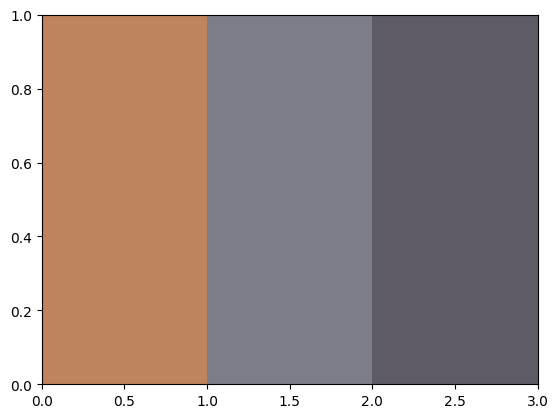

In [87]:
config = Configuration()
config.checkInputFolder()
config.checkOutputFolder()

reportCount = 2 #TODO change to 50
count = 0
end = config.getFileLength()
startTime = time.time()

for gameName in config.getGameNames():
  ageGender = AgeGender(gameName, config.getOutputRoot())
  brightnessAnalyzer = BrightnessAnalyzer(gameName, config.getOutputRoot())
  dominantColor = DominantColor( gameName, config.getOutputRoot())
  averageColor = AverageColor(gameName, config.getOutputRoot())
  emotionDetection = EmotionDetection(gameName, config.getOutputRoot())
  locationDetection = LocationDetection(gameName, config.getOutputRoot())

  framesList = os.listdir(f"{config.getInputRoot()}{gameName}\\")
  framesList = natsorted(framesList, alg=ns.PATH | ns.IGNORECASE)

  for frameName in framesList:
    count += 1

    if not frameName.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
      continue
    
    frameData = cv2.imread(f"{config.getInputRoot()}{gameName}\\{frameName}")
    
    ageGender.handleNextImage(frameName, frameData)
    brightnessAnalyzer.handleNextImage(frameName, frameData)
    dominantColor.handleNextImage(frameName, frameData)
    averageColor.handleNextImage(frameName, frameData)
    emotionDetection.handleNextImage(frameName, frameData)
    locationDetection.handleNextImage(frameName, frameData)
  
    if count % reportCount == 0:
      reportProgress(count, end, gameName, startTime)
    
  #save data as csv
  ageGender.dataToCSV()
  brightnessAnalyzer.dataToCSV()
  dominantColor.dataToCSV()
  averageColor.dataToCSV()
  emotionDetection.dataToCSV()
  locationDetection.dataToCSV()

  #generate color bars
  dominantColor.generateColorBars()
  averageColor.generateColorBars()

  #generate greyscale graph
  brightnessAnalyzer.generateGreyScaleGraph()